# Mengimport library yang dibutuhkan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [ ]:
# Load dataset diabetes
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")

# Initial Exploration

In [ ]:
# Tampilkan 5 baris pertama
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Pada output diatas dapat dilihat bahwa terdapat beberapa fitur prediksi dan 1 fitur target. keterangan dari fitur fitur tersebut sbb:

1. Kehamilan: Jumlah kali hamil
2. Glukosa: Konsentrasi glukosa plasma 2 jam dalam tes toleransi glukosa oral
3. Tekanan Darah: Tekanan darah diastolik (mm Hg)
4. Ketebalan Kulit: Ketebalan lipatan kulit trisep (mm)
5. Insulin: Insulin serum 2 jam (mu U/ml)
6. BMI: Indeks massa tubuh (berat dalam kg/(tinggi dalam m)^2)
7. Fungsi Pedigree Diabetes: Fungsi silsilah diabetes
8. Usia: Usia (tahun)
9. Hasil: Variabel kelas (0 atau 1), di mana 1 menunjukkan pasien menderita diabetes, dan 0 menunjukkan tidak menderita diabetes.

In [ ]:
# mengecek data apakah bernilai null atau tidak
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Hasil pengecekan data diatas menunjukan bahwa tidak data bernilai null

In [ ]:
# mengecek data apakah ada data yang terduplikat
print(df.duplicated().value_counts())

False    768
Name: count, dtype: int64


Dapat dilihat dari output diatas tidak data yang terduplikat

# Exploratory Data Analysis & Data Cleaning

1. Univariate Exploratory Data Analysis

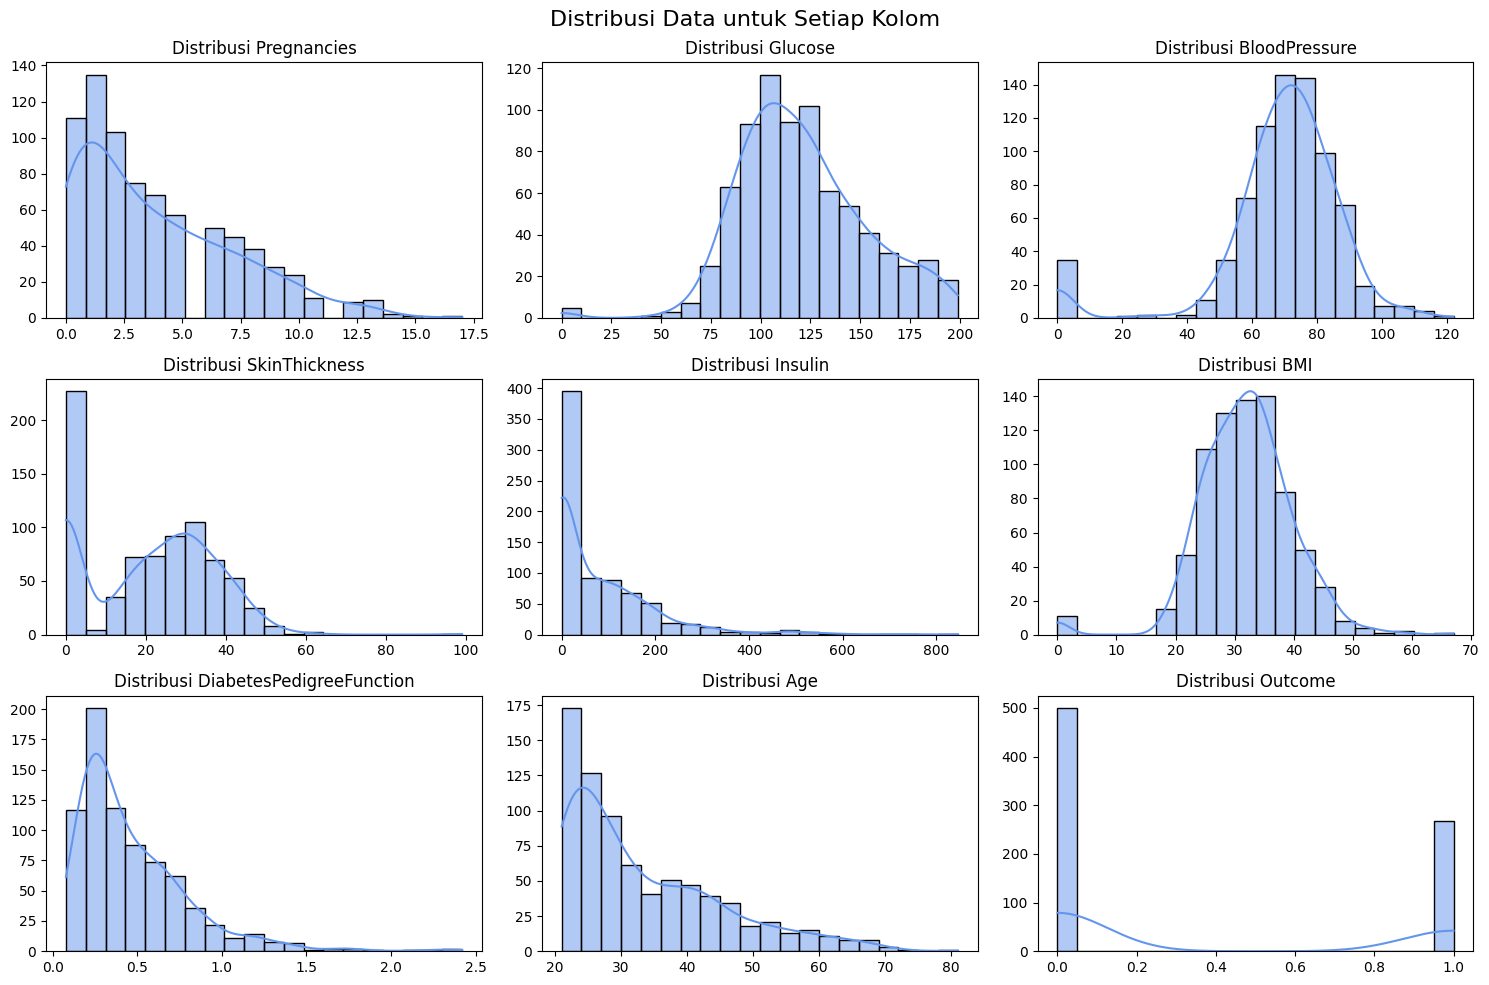

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, kolom in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i]
    sns.histplot(df[kolom], bins=20, kde=True, ax=ax, edgecolor='black', color='cornflowerblue')
    ax.set_title(f'Distribusi {kolom}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Distribusi Data untuk Setiap Kolom", fontsize=16)
plt.tight_layout()
plt.show()

Dari grafis tersebut mempelihatkan kecondongan data bahwa Glukosa, Insulin, Ketebalan Kulit, BMI dan Tekanan Darah yang nilainya 0. Kita dapat menghapus data tersebut atau menggantinya dengan nilai rata-rata masing-masing.

In [ ]:
# Ganti nilai 0 di masing-masing kolom dengan rata-rata kolom tersebut
df['BMI'] = df['BMI'].replace(0, df['BMI'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean())
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].mean())
df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].mean())

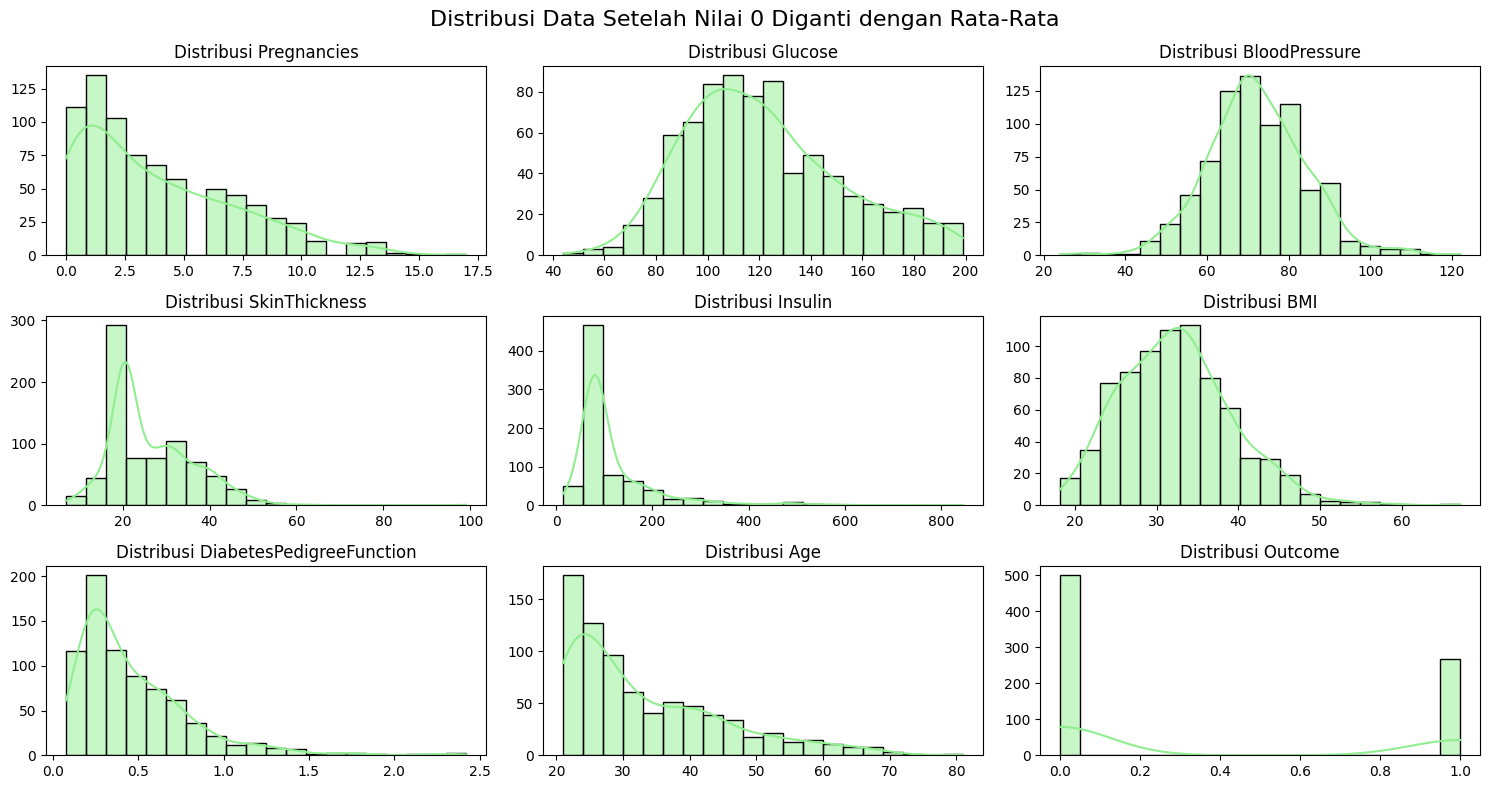

In [ ]:
# Tampilkan histogram setelah penggantian
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, kolom in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i]
    sns.histplot(df[kolom], bins=20, kde=True, ax=ax, edgecolor='black', color='lightgreen')
    ax.set_title(f'Distribusi {kolom}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Distribusi Data Setelah Nilai 0 Diganti dengan Rata-Rata", fontsize=16)
plt.tight_layout()
plt.show()

Dari grafis terlihat bahwa kita telah berhasil menangani nilai 0 dan data terlihat lebih baik dari sebelumnya, namun masih terdapat outlier di beberapa kolom. Mari kita hapus outlier tersebut berdasarkan persentil.

In [ ]:
batas_quantile = {
    'Pregnancies': 0.98,
    'BMI': 0.99,
    'SkinThickness': 0.99,
    'Insulin': 0.95,
    'DiabetesPedigreeFunction': 0.99,
    'Age': 0.99
}

for kolom, q in batas_quantile.items():
    batas = df[kolom].quantile(q)
    df = df[df[kolom] < batas]

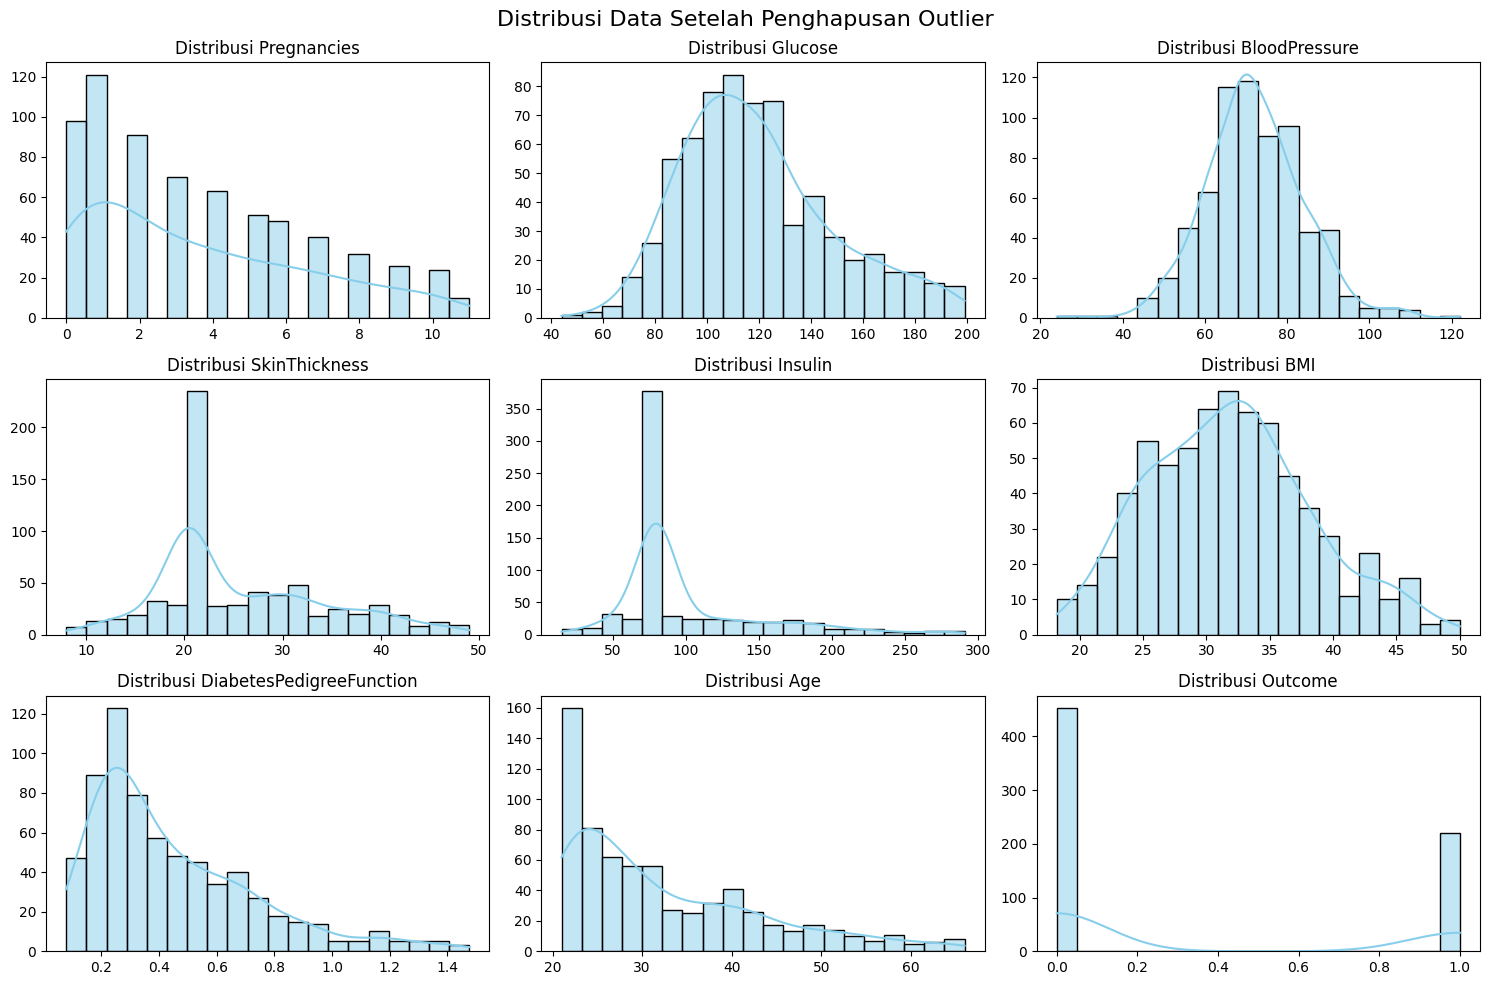

In [ ]:
plt.figure(figsize=(15, 10))

for i, kolom in enumerate(df.select_dtypes(include='number').columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[kolom], kde=True, bins=20, edgecolor='black', color='skyblue')
    plt.title(f'Distribusi {kolom}')
    plt.xlabel('')
    plt.ylabel('')

plt.suptitle("Distribusi Data Setelah Penghapusan Outlier", fontsize=16)
plt.tight_layout()
plt.show()


2. Multivariate Exploratory Data Analysis

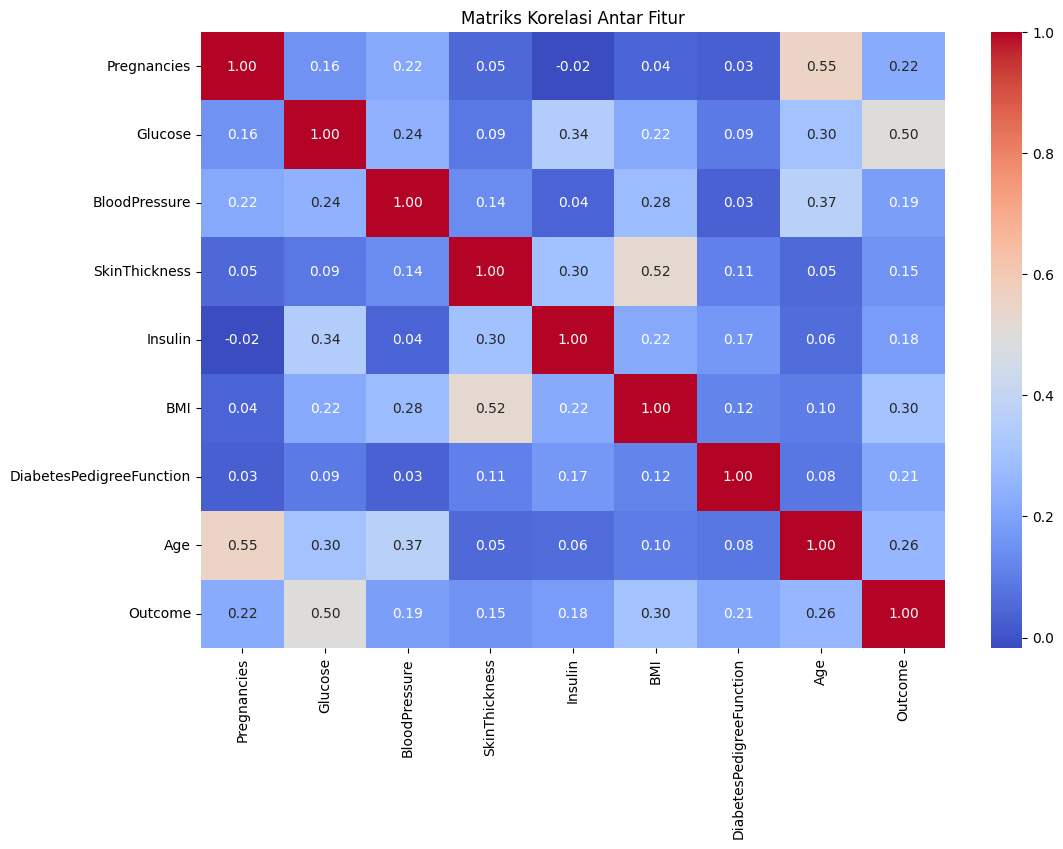

In [ ]:
# Untuk mengetahui hubungan antar fitur numerik.
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi Antar Fitur')
plt.show()

Dari Heatmap diatas dapat kita lihat bahwa warna yang lebih gelap memiliki korelasi yang lebih kuat.

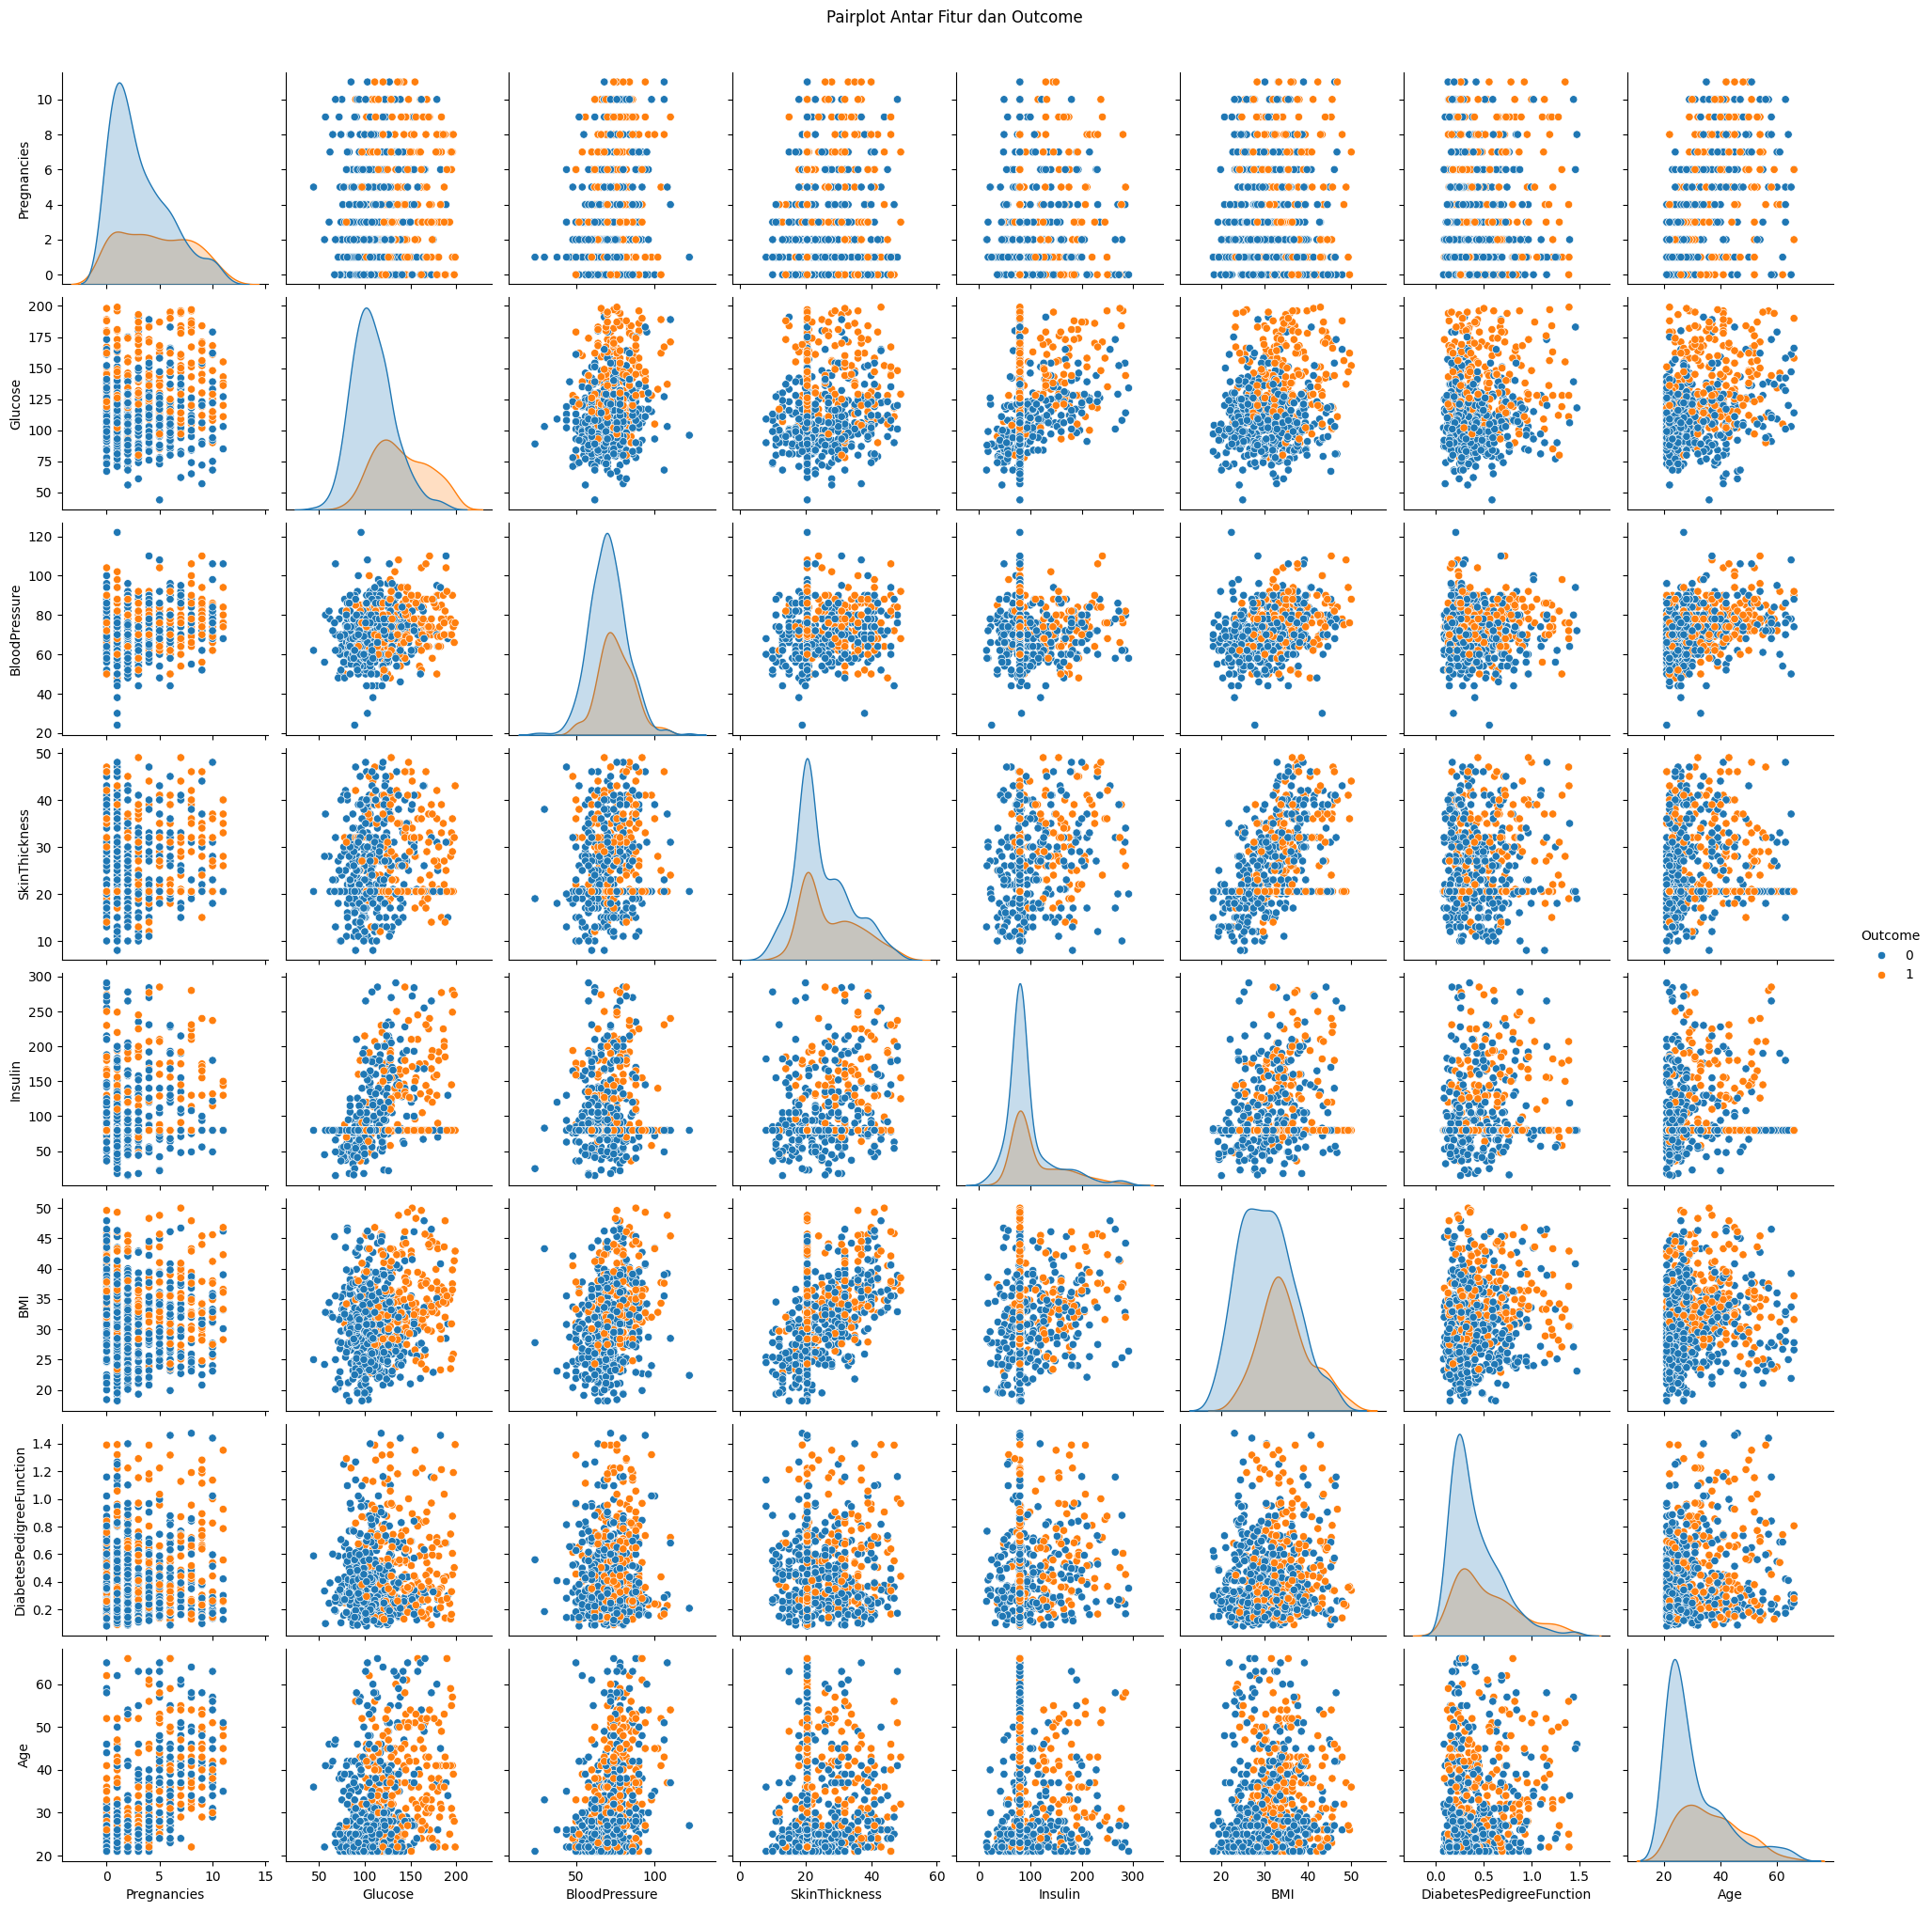

In [ ]:
# Untuk melihat hubungan antar variabel
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot Antar Fitur dan Outcome", y=1.02)
plt.show()

# Data Preprocessing

Setelah melakukan eksplorasi dan pembersihan data, tahap selanjutnya adalah melakukan pra-pemrosesan untuk menyiapkan data sebelum proses pelatihan model.

In [ ]:
# Independen variabel
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Dependen variabel
y = df['Outcome']

Jika telah menentukan kedua variabel tersebut kita akan membagi dataset menjadi data-training dan data-test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Setelah melakukan pembagian data, tahap selanjutnya adalah melakukan normalisasi data. Normalisasi bertujuan untuk menyamakan skala antar fitur, terutama jika fitur-fitur tersebut memiliki rentang nilai yang sangat berbeda.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modeling

Di tahap ini, kita mulai membangun dan melatih model machine learning menggunakan data yang sudah diproses sebelumnya.

**Fungsi: Confusion Matrix dan Classification Report**

Pada bagian ini didefinisikan fungsi evaluasi model yang digunakan untuk menampilkan confusion matrix dalam bentuk visual (heatmap), serta classification report untuk menilai performa model.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluasi_model(nama_model, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Positif'],
                yticklabels=['Negatif', 'Positif'])
    plt.title(f"Confusion Matrix - {nama_model}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()
    plt.show()

    print(f"\nClassification Report - {nama_model}:\n")
    print(classification_report(y_true, y_pred))

**1. Pelatihan dan Evaluasi Model Logistic Regression**

Di bagian ini kita melakukan pelatihan model Logistic Regression menggunakan data training. Setelah itu, model diuji dengan data testing dan dievaluasi menggunakan fungsi evaluasi_model yang telah dibuat sebelumnya.

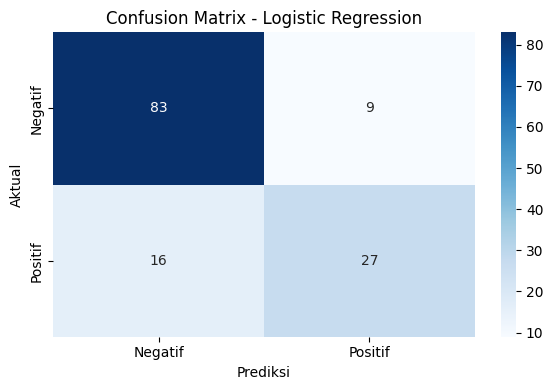


Classification Report - Logistic Regression:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        92
           1       0.75      0.63      0.68        43

    accuracy                           0.81       135
   macro avg       0.79      0.77      0.78       135
weighted avg       0.81      0.81      0.81       135



In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

evaluasi_model("Logistic Regression", y_test, y_pred_logreg)

Dari output diatas dapat lihat Confusion Matrix menunjukkan bahwa model berhasil mengklasifikasikan 83 pasien non-diabetes dan 27 pasien diabetes dengan benar, sementara terdapat 9 kasus false positive (prediksi diabetes padahal tidak) dan 16 kasus false negative (tidak terdeteksi sebagai diabetes padahal sebenarnya positif). Sementara itu dari hasil Classification Report, model memiliki akurasi keseluruhan sebesar 81%, dengan precision 84% dan recall 90% untuk kelas non-diabetes (0), serta precision 75% dan recall 63% untuk kelas diabetes (1). Ini menunjukkan bahwa model cukup baik dalam mengenali pasien non-diabetes, namun masih memiliki kelemahan dalam mendeteksi pasien yang benar-benar menderita diabetes, yang terlihat dari recall yang lebih rendah pada kelas 1.

**2. Pelatihan dan Evaluasi Model K-Nearest Neighbors**

Di bagian ini kita melakukan pelatihan model K-Nearest Neighbors menggunakan data training. Setelah itu, model diuji dengan data testing dan dievaluasi menggunakan fungsi evaluasi_model yang telah dibuat sebelumnya.

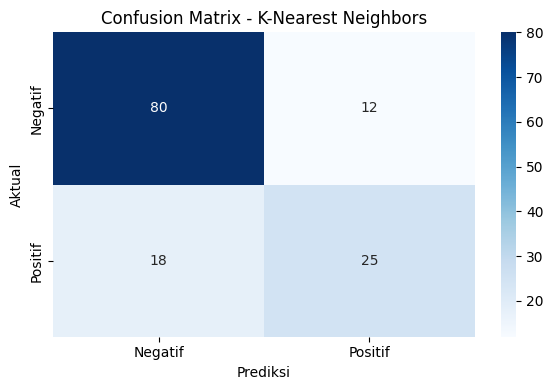


Classification Report - K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        92
           1       0.68      0.58      0.62        43

    accuracy                           0.78       135
   macro avg       0.75      0.73      0.73       135
weighted avg       0.77      0.78      0.77       135



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

evaluasi_model("K-Nearest Neighbors", y_test, y_pred_knn)

Confusion Matrix dari model K-Nearest Neighbors (KNN) menunjukkan bahwa model berhasil mengklasifikasikan 80 pasien non-diabetes dan 25 pasien diabetes dengan benar, namun terdapat 12 kasus false positive (pasien diprediksi diabetes padahal tidak) dan 18 kasus false negative (pasien tidak terdeteksi diabetes padahal sebenarnya positif). Berdasarkan Classification Report, model ini memiliki akurasi sebesar 78%. Untuk kelas non-diabetes (0), precision-nya 82% dan recall-nya 87%, menunjukkan bahwa model cukup handal dalam mendeteksi pasien yang tidak memiliki diabetes. Namun, performa pada kelas diabetes (1) masih kurang optimal, dengan precision 68% dan recall 58%, yang mengindikasikan model masih cukup sering salah mendeteksi pasien yang seharusnya positif diabetes. Secara keseluruhan, performa KNN sedikit di bawah Logistic Regression, terutama dalam mengenali kasus diabetes.

**3. Pelatihan dan Evaluasi Model Decision Tree**

Di bagian ini kita melakukan pelatihan model Decision Tree menggunakan data training. Setelah itu, model diuji dengan data testing dan dievaluasi menggunakan fungsi evaluasi_model yang telah dibuat sebelumnya.

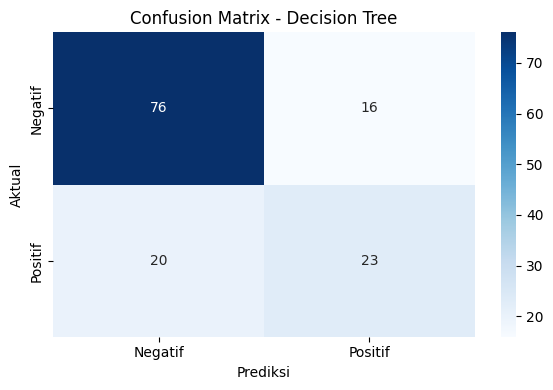


Classification Report - Decision Tree:

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        92
           1       0.59      0.53      0.56        43

    accuracy                           0.73       135
   macro avg       0.69      0.68      0.68       135
weighted avg       0.73      0.73      0.73       135



In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

evaluasi_model("Decision Tree", y_test, y_pred_tree)

Model Decision Tree menghasilkan performa yang cenderung seimbang namun belum optimal, terutama dalam mendeteksi kasus diabetes. Confusion matrix menunjukkan bahwa dari 92 pasien non-diabetes, 76 berhasil diprediksi dengan benar, sementara 16 salah diklasifikasikan sebagai penderita diabetes. Di sisi lain, dari 43 pasien yang benar-benar mengidap diabetes, hanya 23 yang terdeteksi dengan benar, sedangkan 20 lainnya tidak terdeteksi oleh model. Hal ini mencerminkan ketidakseimbangan dalam kemampuan model mengenali kelas positif. Hasil classification report memperkuat hal tersebut, dengan precision kelas 1 (positif diabetes) hanya 0.59 dan recall sebesar 0.53. Meskipun akurasi keseluruhan sebesar 73% terdengar cukup baik, nilai recall yang rendah pada kelas positif menunjukkan bahwa model ini masih kurang sensitif terhadap pasien yang benar-benar memiliki diabetes.

**4. Pelatihan dan Evaluasi Model Random Forest**

Di bagian ini kita melakukan pelatihan model Random Forest menggunakan data training. Setelah itu, model diuji dengan data testing dan dievaluasi menggunakan fungsi evaluasi_model yang telah dibuat sebelumnya.

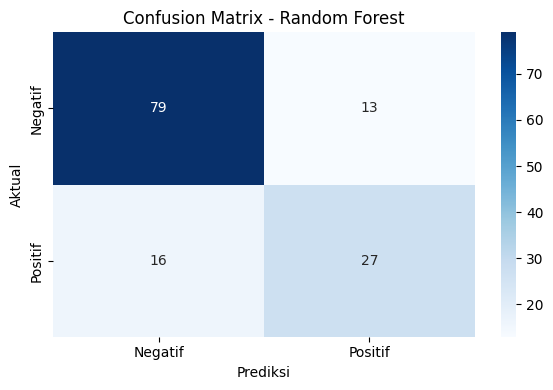


Classification Report - Random Forest:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        92
           1       0.68      0.63      0.65        43

    accuracy                           0.79       135
   macro avg       0.75      0.74      0.75       135
weighted avg       0.78      0.79      0.78       135



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluasi_model("Random Forest", y_test, y_pred_rf)

Model Random Forest menunjukkan bahwa dari 92 pasien yang sebenarnya tidak menderita diabetes (kelas 0), sebanyak 79 pasien berhasil diklasifikasikan dengan benar, sementara 13 pasien keliru diklasifikasikan sebagai positif diabetes. Untuk kelas 1 (sebenarnya menderita diabetes), dari 43 pasien, model berhasil memprediksi 27 pasien dengan benar, dan 16 sisanya salah diklasifikasikan sebagai non-diabetes.

Dalam Classification Report, kita bisa lihat bahwa model ini memiliki akurasi keseluruhan sebesar 79%, yang berarti 79% dari seluruh prediksi cocok dengan label sebenarnya. Untuk kelas 0, nilai precision 0.83 dan recall 0.86 mengindikasikan bahwa model cukup baik dalam mengidentifikasi pasien non-diabetes. Namun, untuk kelas 1, precision-nya 0.68 dan recall 0.63, menunjukkan bahwa performa model dalam mengenali pasien yang benar-benar menderita diabetes masih kurang baik.

**5. Pelatihan dan Evaluasi Model Support Vector Machine**

Di bagian ini kita melakukan pelatihan model Support Vector Machine menggunakan data training. Setelah itu, model diuji dengan data testing dan dievaluasi menggunakan fungsi evaluasi_model yang telah dibuat sebelumnya.

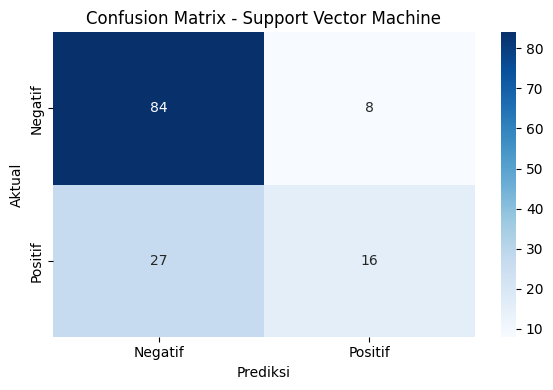


Classification Report - Support Vector Machine:

              precision    recall  f1-score   support

           0       0.76      0.91      0.83        92
           1       0.67      0.37      0.48        43

    accuracy                           0.74       135
   macro avg       0.71      0.64      0.65       135
weighted avg       0.73      0.74      0.72       135



In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

evaluasi_model("Support Vector Machine", y_test, y_pred_svm)

Model Support Vector Machine (SVM) ini menunjukkan bahwa model sangat baik dalam mengenali pasien yang tidak menderita diabetes (kelas 0) — sebanyak 85 dari 92 pasien berhasil diprediksi dengan benar, hanya 8 yang salah diklasifikasikan. Namun, untuk pasien yang menderita diabetes (kelas 1), performa model masih kurang optimal, hanya 16 dari 43 yang terdeteksi dengan tepat, dan sebanyak 27 pasien salah diprediksi sebagai non-diabetes.

Dari laporan klasifikasinya, terlihat bahwa meskipun precision untuk kelas 1 adalah 0.67, recall-nya hanya 0.37, artinya banyak pasien diabetes yang tidak terdeteksi. Ini berkontribusi terhadap f1-score kelas 1 yang rendah, yaitu 0.48. Secara keseluruhan, model memperoleh akurasi sebesar 74%, namun distribusi kinerja antar kelas kurang seimbang.

**Perbandingan Akurasi Antar Model Klasifikasi**

Setelah melatih dan mengevaluasi setiap model menggunakan metrik seperti confusion matrix dan classification report, langkah selanjutnya adalah membandingkan performa keseluruhan model melalui akurasi. Model yang dibandingkan adalah:

* Logistic Regression

* K-Nearest Neighbors (KNN)

* Decision Tree

* Random Forest

* Support Vector Machine (SVM)

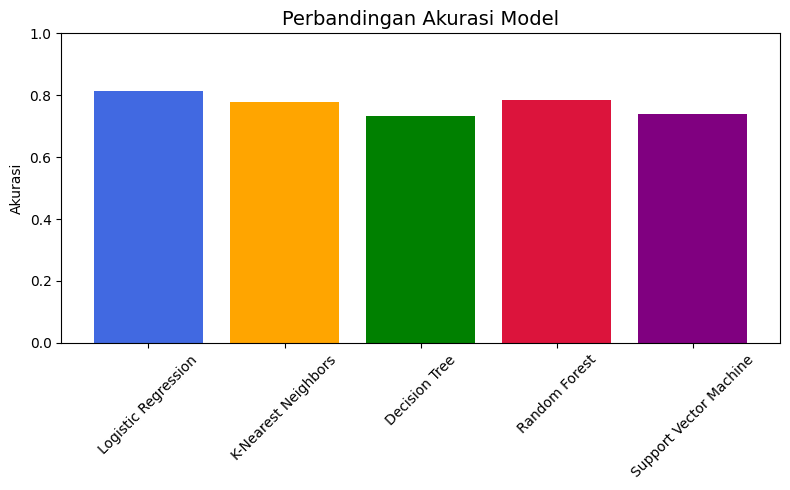

In [ ]:
scores = {
    "Logistic Regression": accuracy_score(y_test, y_pred_logreg),
    "K-Nearest Neighbors": accuracy_score(y_test, y_pred_knn),
    "Decision Tree": accuracy_score(y_test, y_pred_tree),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Support Vector Machine": accuracy_score(y_test, y_pred_svm)
}

colors = ['royalblue', 'orange', 'green', 'crimson', 'purple']

plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color=colors)
plt.title("Perbandingan Akurasi Model", fontsize=14)
plt.ylabel("Akurasi")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Grafik di atas menunjukkan bahwa Logistic Regression menjadi kandidat model terbaik secara akurasi, diikuti oleh Random Forest dan KNN.

Model seperti SVM dan Decision Tree masih menghadapi masalah dalam menangani kelas minoritas (pasien diabetes), meskipun mereka bekerja cukup baik pada kelas mayoritas.

# Prediksi Data Baru Menggunakan Model Logistic Regression

Pada tahap ini, model Logistic Regression yang telah dilatih sebelumnya digunakan untuk melakukan prediksi terhadap data pasien baru yang belum diketahui status diabetesnya. Data pasien dimasukkan dalam bentuk array yang mencakup 8 fitur medis seperti jumlah kehamilan, kadar glukosa, tekanan darah, ketebalan kulit, kadar insulin, BMI, fungsi silsilah diabetes, dan usia.

Model kemudian memprediksi apakah pasien mengidap diabetes (1) atau tidak mengidap diabetes (0) serta menghitung probabilitas dari kedua kemungkinan tersebut.

In [ ]:
data_baru = np.array([[8, 183, 64, 0, 0, 23.3, 0.672, 32]])

# Contoh data uji lainnya
# Mengidap penyakit diabetes (0, 137, 40, 35, 168, 43.1, 2.288, 33)
# Tidak mengidap penyakit diabetes (1, 95, 70, 20, 79, 25.3, 0.2, 22)

prediksi = logreg.predict(data_baru)

probabilitas = logreg.predict_proba(data_baru)[0]

if prediksi[0] == 1:
    print(f"\nHasil prediksi menunjukkan {probabilitas[1]*100:.2f}% kemungkinan pasien MENGIDAP diabetes. Disarankan untuk segera memeriksakan diri ke dokter.")
    print(f"Sementara itu, kemungkinan TIDAK mengidap diabetes sebesar {probabilitas[0]*100:.2f}%.")
else:
    print(f"\nHasil prediksi menunjukkan {probabilitas[0]*100:.2f}% kemungkinan pasien TIDAK mengidap diabetes.")
    print(f"Sementara itu, kemungkinan MENGIDAP diabetes sebesar {probabilitas[1]*100:.2f}%.")


Hasil prediksi menunjukkan 85.13% kemungkinan pasien MENGIDAP diabetes. Disarankan untuk segera memeriksakan diri ke dokter.
Sementara itu, kemungkinan TIDAK mengidap diabetes sebesar 14.87%.


Output prediksi yang dihasilkan oleh model menunjukkan bahwa model memiliki kemampuan yang baik dalam membedakan pasien yang berisiko mengidap diabetes dan yang tidak. Hal ini terlihat dari probabilitas yang dihasilkan, misalnya, ketika pasien diprediksi mengidap diabetes, model menunjukkan probabilitas sebesar 85.13%, sedangkan untuk pasien yang tidak mengidap diabetes, probabilitas mencapai 95.81%. Perbedaan probabilitas yang cukup jelas ini menandakan bahwa model dapat mengklasifikasikan dua kelas dengan baik